In [ ]:
# all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai2.torch_basics import *
from fastai2.basics import *
from fastai2.data.all import *
from fastai2.callback.all import *
from fastai2.vision.all import *

from fastai2_audio.core import *
from fastai2_audio.augment import *

import torchaudio

In [ ]:
from fastprogress import progress_bar as pb

# The Free Digit Dataset

The [Free Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset) is meant to be an audio version of MNIST, and is great for testing purposes. It has 2000 recordings, 4 speakers saying each digit 50 times. First let's grab the data.

In [ ]:
path_digits = untar_data(URLs.DIGITS, extract_func=tar_extract_at_filename)/"recordings"

In [ ]:
# pull out just the audio files 
files_digits = get_audio_files(path_digits)

In [ ]:
files_digits[:5]

(#5) [Path('/home/jupyter/.fastai/data/recordings.tar/recordings/8_jackson_20.wav'),Path('/home/jupyter/.fastai/data/recordings.tar/recordings/5_yweweler_30.wav'),Path('/home/jupyter/.fastai/data/recordings.tar/recordings/9_nicolas_27.wav'),Path('/home/jupyter/.fastai/data/recordings.tar/recordings/6_nicolas_34.wav'),Path('/home/jupyter/.fastai/data/recordings.tar/recordings/8_yweweler_7.wav')]

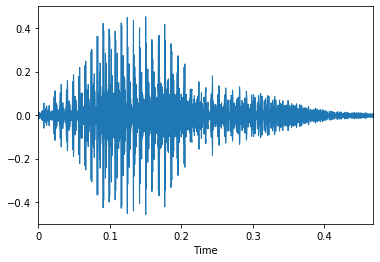

In [ ]:
# Open the 6th file and display it
audio_example = AudioTensor.create(files_digits[5])
audio_example.show()

## What we pass to our model

While it is completely possible to train on raw audio by passing a 1D tensor of the signal to our model, it is much more easy/common to convert the audio to a spectrogram (a 2D image with frequency data) and train on that

In [ ]:
cfg_voice = AudioConfig.Voice()
a2s = AudioToSpec.from_cfg(cfg_voice)
tfms = [CropSignal(1000), a2s]

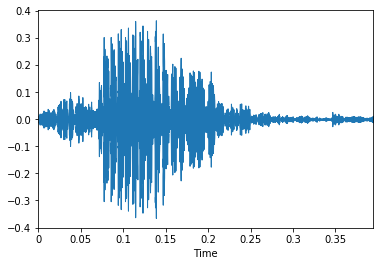

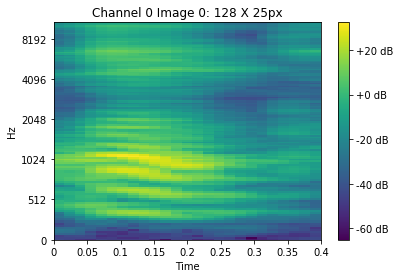

--------------------------------------------------------------------------------


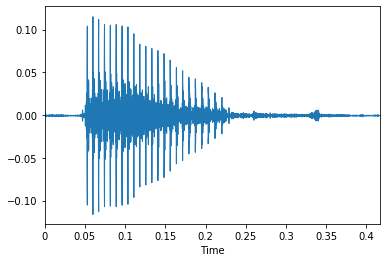

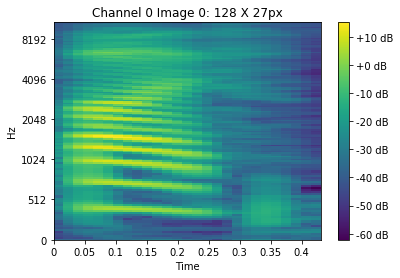

--------------------------------------------------------------------------------


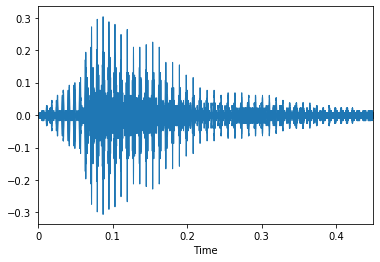

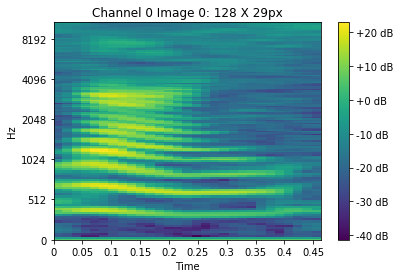

--------------------------------------------------------------------------------


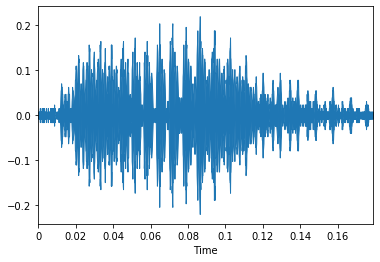

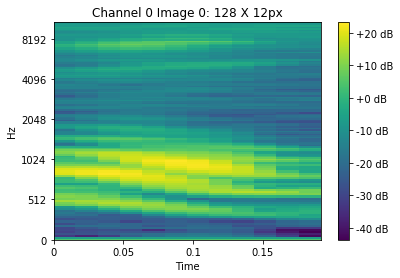

--------------------------------------------------------------------------------


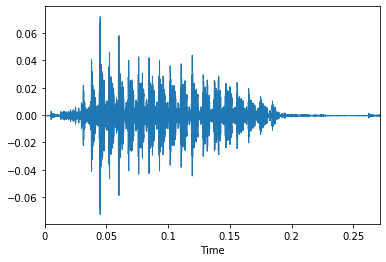

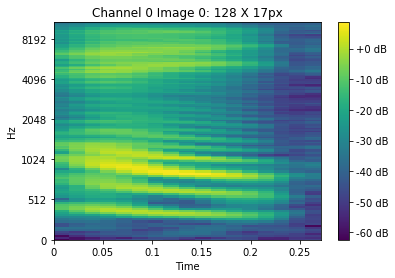

--------------------------------------------------------------------------------


In [ ]:
for fn in files_digits[:5]:
    audio = AudioTensor.create(fn)
    audio.show()
    a2s(audio).show()
    print('-'*80)

### Training a model using melspectrogram and the DataBlock API

We need to make sure to use...
- an AudioBlock
- the appropriate getter function (get_audio_files)
- our audio transforms
- our labeler, which in this case just grabs the first digit of the filename

In [ ]:
tfms = [CropSignal(1000), a2s]

In [ ]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = tfms,
                 get_y=lambda x: str(x).split('/')[-1][0])

In [ ]:
dbunch = auds.dataloaders(path_digits, bs=64)

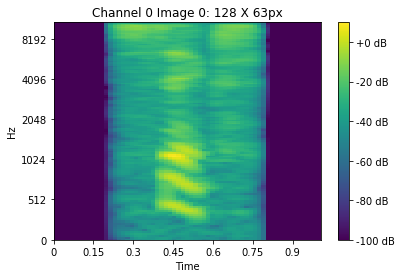

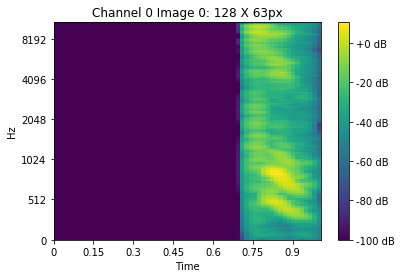

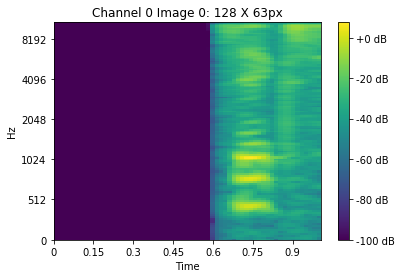

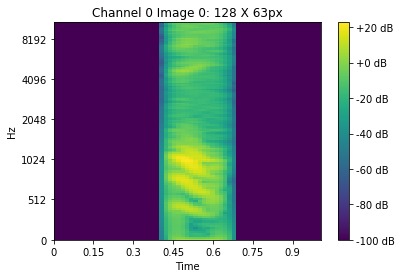

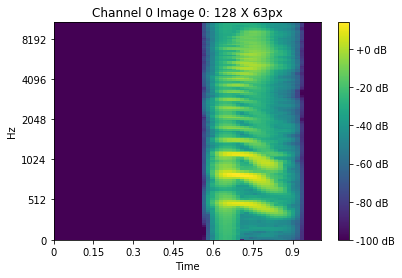

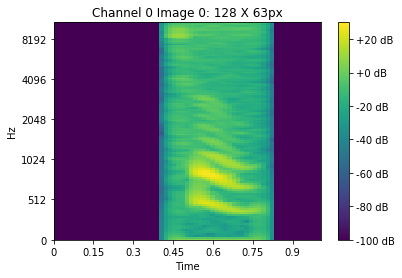

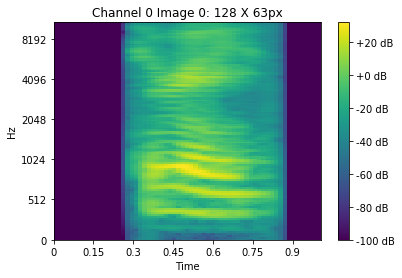

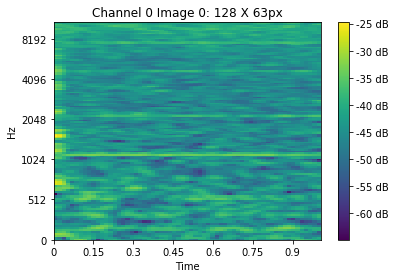

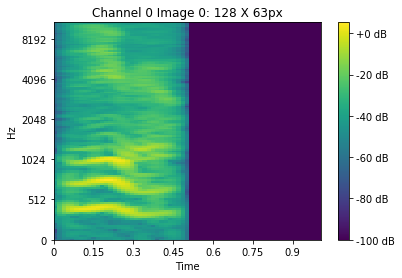

6
2
6
6
3
2
3
7
0


In [ ]:
dbunch.show_batch()

In [ ]:
# credit to Kevin Bird and Hiromi Suenaga for these two lines to adjust a CNN model to take 1 channel input
def alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [ ]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

(0.09120108485221863, 0.004365158267319202)

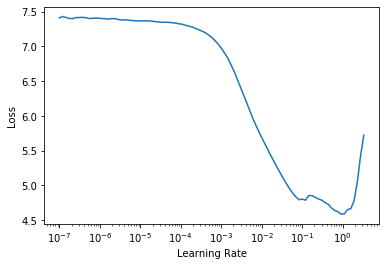

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.510412,15.895768,0.100000,00:03
1,2.354349,5.729151,0.235000,00:02
2,1.564828,1.162702,0.587500,00:02
3,1.005792,0.248753,0.915000,00:02
4,0.649495,0.172403,0.955000,00:02


In [ ]:
learn.fit_one_cycle(5, lr_max=slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.146847,0.147921,0.960000,00:02
1,0.137223,0.172566,0.945000,00:02
2,0.120546,0.115176,0.970000,00:02
3,0.105050,0.118478,0.967500,00:02
4,0.090334,0.080658,0.982500,00:02


### Using fancier audio trans

To get a good result on this simple dataset, we only need to crop to a single length, and convert to a spectrogram, but I'll add in some transforms that might be useful if you're overfitting.

Instead of using the default configs for our Spectrogram generator, let's pass in settings manually

In [ ]:
# we still want a decibel scale melspectrogram
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

In [ ]:
a2s = DBMelSpec(n_mels=128, f_max=10000, n_fft=1024, hop_length=128, top_db=100)

In [ ]:
tfms = [CropSignal(1000), a2s]
# we could redo the whole auds block, or we can just swap in our new transform pipeline
auds.item_tfms = tfms
# tfms = Pipeline([CropSignal(4000),  a2s, MaskFreq(size=12), MaskTime(size=15), SGRoll()], as_item=True)
dbunch_fancy = auds.dataloaders(path_digits, bs=128)

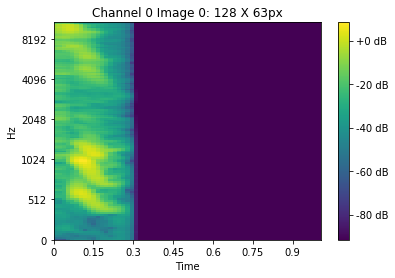

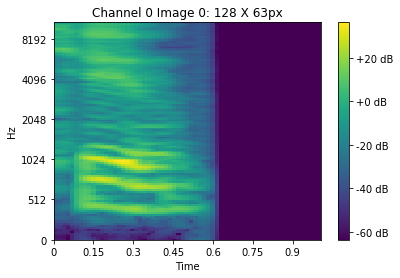

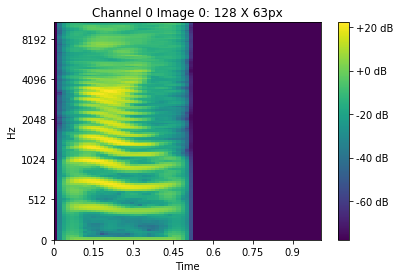

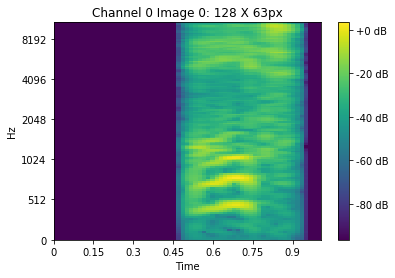

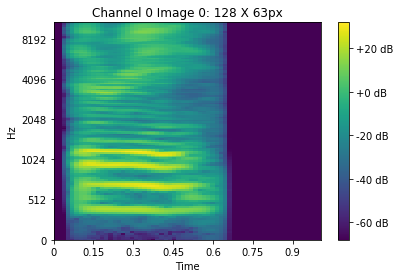

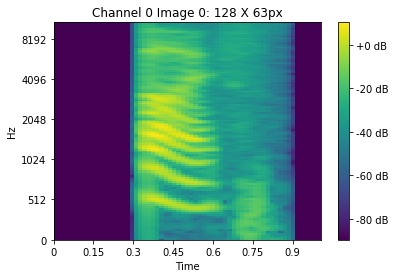

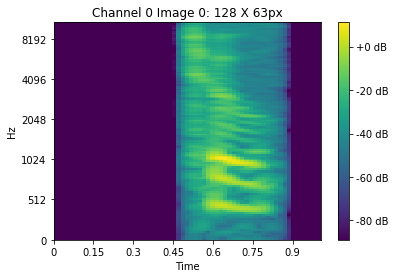

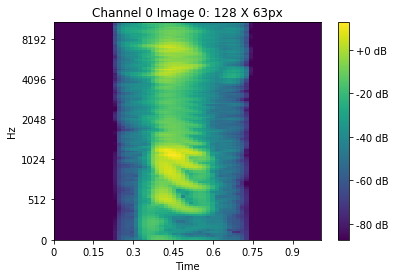

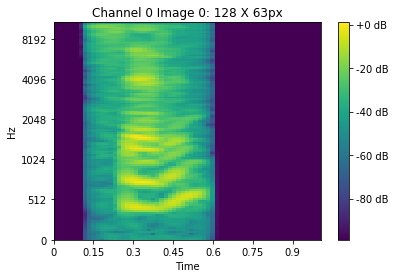

/
/
/
/
/
/
/
/
/


In [ ]:
dbunch_fancy.show_batch()

In [ ]:
learn = Learner(dbunch_fancy, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch_fancy.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

(0.33113112449646, 0.002511886414140463)

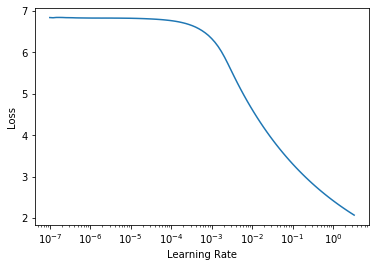

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,6.227656,5.409506,0.030000,00:02
1,4.005870,0.309783,1.000000,00:02
2,2.380064,0.028136,1.000000,00:02
3,1.561864,0.015198,1.000000,00:02
4,1.087989,0.014717,1.000000,00:02


### Using Mel Frequency Cepstral Coefficient (MFCC)

In [ ]:
a2mfcc = AudioToMFCC(n_mfcc=20, melkwargs={"n_fft":2048, "hop_length":256, "n_mels":128})
tfms = [CropSignal(1000), a2mfcc]
# we could redo the whole auds block, or we can just swap in our new transform pipeline
auds.item_tfms = tfms
# tfms = Pipeline([CropSignal(4000),  a2s, MaskFreq(size=12), MaskTime(size=15), SGRoll()], as_item=True)
dbunch_mfcc = auds.dataloaders(path_digits, bs=128)

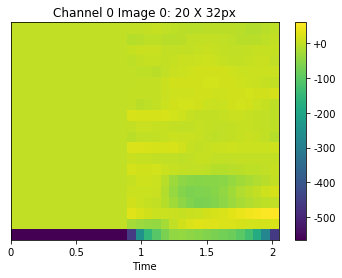

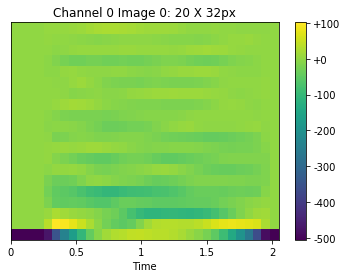

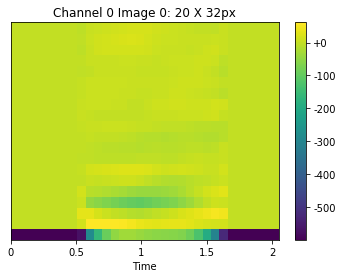

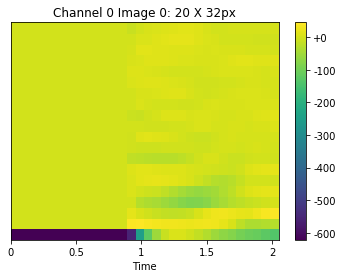

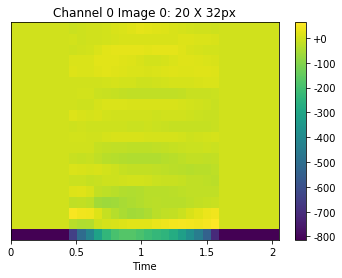

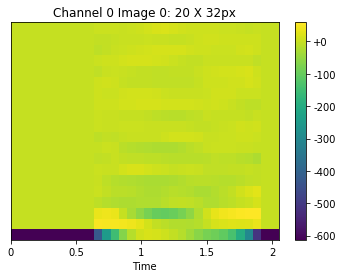

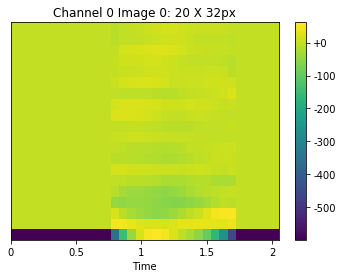

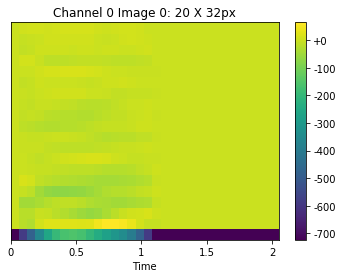

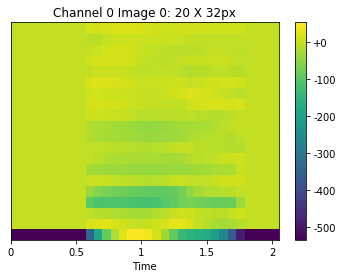

/home/jupyter/rob/free-spoken-digit-dataset/recordings/2
/home/jupyter/rob/free-spoken-digit-dataset/recordings/0
/home/jupyter/rob/free-spoken-digit-dataset/recordings/4
/home/jupyter/rob/free-spoken-digit-dataset/recordings/8
/home/jupyter/rob/free-spoken-digit-dataset/recordings/7
/home/jupyter/rob/free-spoken-digit-dataset/recordings/9
/home/jupyter/rob/free-spoken-digit-dataset/recordings/7
/home/jupyter/rob/free-spoken-digit-dataset/recordings/2
/home/jupyter/rob/free-spoken-digit-dataset/recordings/8


In [ ]:
dbunch_mfcc.show_batch()

In [ ]:
learn = Learner(dbunch_mfcc, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch_mfcc.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

(0.09120108485221863, 0.002511886414140463)

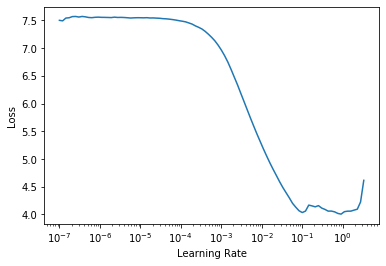

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.860404,2.305557,0.305000,00:01
1,1.931265,3.943319,0.390000,00:01
2,1.192746,1.045461,0.660000,00:01
3,0.810215,0.392439,0.875000,00:01
4,0.575550,0.094060,0.970000,00:01


In [ ]:
learn.fit_one_cycle(5, lr_max=slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.044840,0.069590,0.975000,00:01
1,0.034747,0.062901,0.980000,00:01
2,0.027268,0.044406,0.987500,00:01
3,0.022468,0.055741,0.980000,00:01
4,0.021057,0.050270,0.987500,00:01


### Free Digit MFCC + Delta

In [ ]:
a2mfcc = AudioToMFCC(n_mfcc=20, melkwargs={"n_fft":2048, "hop_length":256, "n_mels":128})
tfms = [CropSignal(1000), a2mfcc, Delta()]
auds.item_tfms = tfms
# tfms = Pipeline([CropSignal(4000),  a2s, MaskFreq(size=12), MaskTime(size=15), SGRoll()], as_item=True)
dbunch_mfcc = auds.dataloaders(path_digits, bs=128)

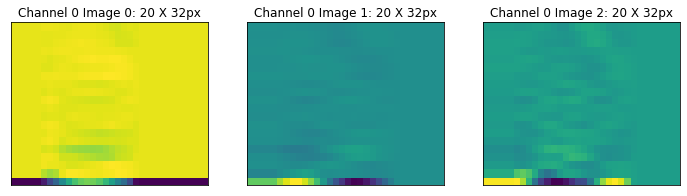

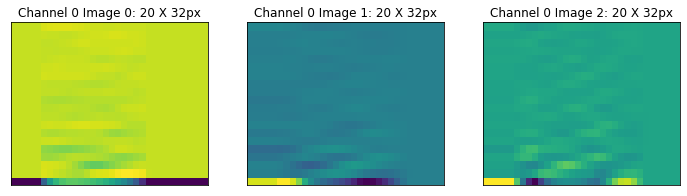

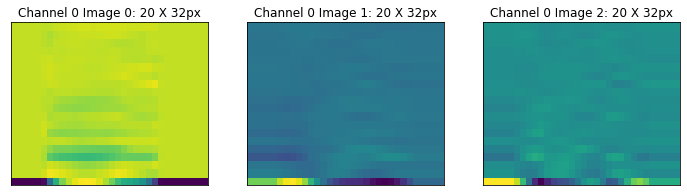

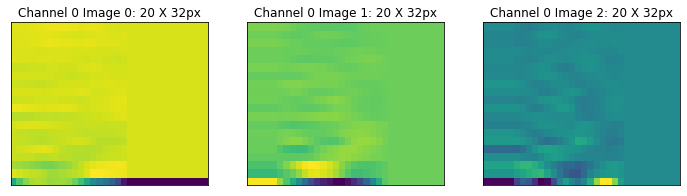

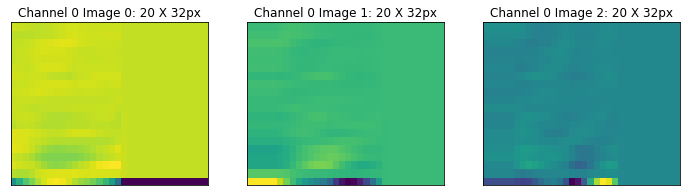

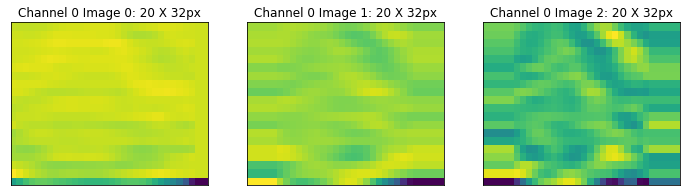

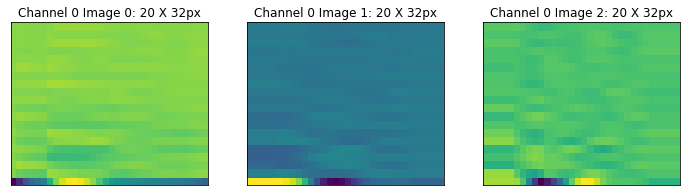

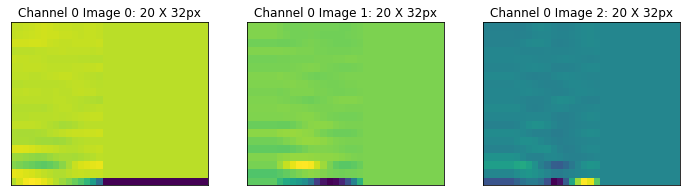

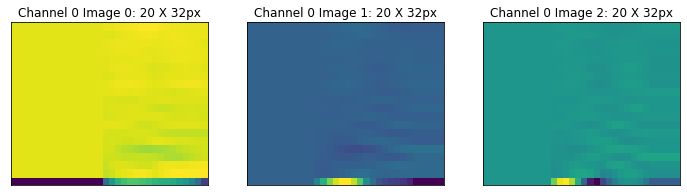

/home/jupyter/rob/free-spoken-digit-dataset/recordings/3
/home/jupyter/rob/free-spoken-digit-dataset/recordings/0
/home/jupyter/rob/free-spoken-digit-dataset/recordings/8
/home/jupyter/rob/free-spoken-digit-dataset/recordings/9
/home/jupyter/rob/free-spoken-digit-dataset/recordings/7
/home/jupyter/rob/free-spoken-digit-dataset/recordings/9
/home/jupyter/rob/free-spoken-digit-dataset/recordings/6
/home/jupyter/rob/free-spoken-digit-dataset/recordings/5
/home/jupyter/rob/free-spoken-digit-dataset/recordings/3


In [ ]:
dbunch_mfcc.show_batch()

In [ ]:
learn = Learner(dbunch_mfcc, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])

(0.014454397559165954, 0.0030199517495930195)

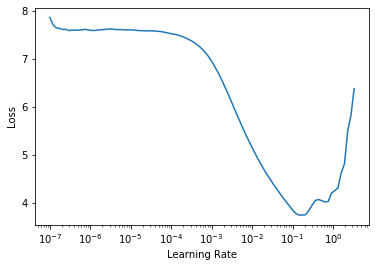

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.621129,2.961579,0.165000,00:02
1,1.761448,1.282643,0.632500,00:02
2,1.090677,1.425554,0.615000,00:02
3,0.737770,0.268777,0.922500,00:02
4,0.527587,0.088852,0.972500,00:02


In [ ]:
learn.fit_one_cycle(5, lr_max=slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.039698,0.052616,0.985000,00:02
1,0.032759,0.049447,0.980000,00:02
2,0.028881,0.055963,0.977500,00:02
3,0.025799,0.038528,0.985000,00:02
4,0.022969,0.042401,0.987500,00:02
